# Setting Up Our Workspace.

#### Importing necessary libraries

In [13]:
from importlib import reload
# custom functions 
import helper_functions as hf

import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import pandas as pd
import seaborn as sns

import scipy.stats as scs
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime
from datetime import timedelta
import warnings
from scipy.stats import mstats
warnings.filterwarnings('ignore')
reload(hf )

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\dsc-mod-3-project-online-ds-ft-090919\\helper_functions.py'>

#### Setting Up The Connection to the Database

In [14]:
# Setting up the connection to the database
conn, cursor = hf.connection()

In [15]:
hf.get_tables(cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q3 - We will investigate the effect of employment length on order total

H0 - Employment Length does __NOT__ have a statistically significant effect on sales.<br>
HA - Employment Length __DOES__ have a statistically significant effect on sales per unit.

In [16]:
query = '''select e.hiredate, od.unitprice, od.quantity, od.discount,
           ((od.unitprice* (1-od.discount)) * od.quantity) as totalprice
           from employee e 
           JOIN [Order] o on e.id=o.employeeid
           JOIN [OrderDetail] od on od.OrderId=o.Id
'''

df = hf.query_to_df(query, conn)
df.head()

,HireDate,UnitPrice,Quantity,Discount,totalprice
0,2025-10-17,14.0,12,0.0,168.0
1,2025-10-17,9.8,10,0.0,98.0
2,2025-10-17,34.8,5,0.0,174.0
3,2025-10-17,18.6,9,0.0,167.4
4,2025-10-17,42.4,40,0.0,1696.0


In [17]:
df['HireDate'].unique()

array(['2025-10-17', '2025-05-03', '2024-04-01', '2026-11-15',
       '2024-05-01', '2026-03-05', '2024-08-14', '2026-01-02'],
      dtype=object)

First we will need to convert the date to a usable number.

In [18]:
pd.to_datetime(df.HireDate, infer_datetime_format=True);

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
HireDate      2155 non-null object
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
totalprice    2155 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 84.3+ KB


In [20]:
def date_diff(t1, t2):
    diff = datetime.datetime.strptime(t1, '%Y-%m-%d') - datetime.datetime.strptime(t2, '%Y-%m-%d')
    return diff.days
start_date = df.HireDate.max()        
df['len_employment'] = [date_diff(start_date, row.HireDate) for index, row in df.iterrows()]
df.head()

,HireDate,UnitPrice,Quantity,Discount,totalprice,len_employment
0,2025-10-17,14.0,12,0.0,168.0,394
1,2025-10-17,9.8,10,0.0,98.0,394
2,2025-10-17,34.8,5,0.0,174.0,394
3,2025-10-17,18.6,9,0.0,167.4,394
4,2025-10-17,42.4,40,0.0,1696.0,394


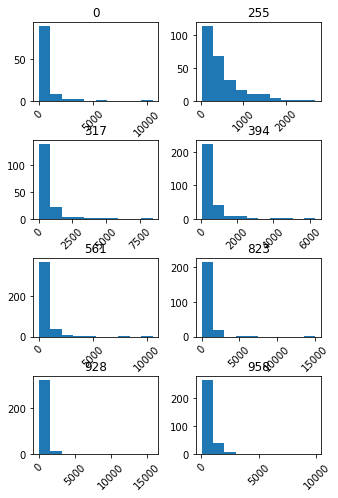

In [21]:
 df.hist('totalprice', by='len_employment', figsize=(5,8), layout=(4,2), xrot=45);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5686CFF60>]],
      dtype=object)

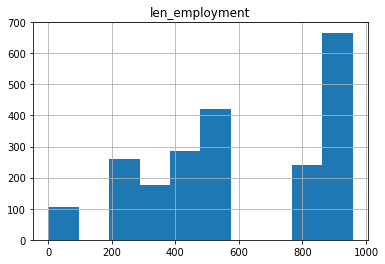

In [22]:
df.hist('len_employment')

In [23]:
tenure = list(df.len_employment.unique())
tenure

[394, 561, 958, 0, 928, 255, 823, 317]

In [24]:
len_0 = df.loc[df['len_employment'] == 0]
len_255 = df.loc[df['len_employment'] == 255]
len_317 = df.loc[df['len_employment'] == 317]
len_394 = df.loc[df['len_employment'] == 394]
len_561 = df.loc[df['len_employment'] == 561]
len_823 = df.loc[df['len_employment'] == 823]
len_928 = df.loc[df['len_employment'] == 928]
len_958 = df.loc[df['len_employment'] == 958]

len_0 = len_0['totalprice']
len_255 = len_255['totalprice']
len_317 = len_317['totalprice']
len_394 = len_394['totalprice']
len_561 = len_561['totalprice']
len_823 = len_823['totalprice']
len_928 = len_928['totalprice']
len_958 = len_958['totalprice']

print('len_0')
print(hf.test_normality(len_0))
print('len_255')
print(hf.test_normality(len_255))
print('len_317')
print(hf.test_normality(len_317))
print('len_394')
print(hf.test_normality(len_394))
print('len_561')
print(hf.test_normality(len_561))
print('len_823')
print(hf.test_normality(len_823))
print('len_928')
print(hf.test_normality(len_928))
print('len_958')
print(hf.test_normality(len_958))

len_0
p= 7.304625194302649e-18
 The data is not normally distributed.
False
len_255
p= 4.103233068163989e-17
 The data is not normally distributed.
False
len_317
p= 6.9448335356879765e-22
 The data is not normally distributed.
False
len_394
p= 1.3690730313917236e-25
 The data is not normally distributed.
False
len_561
p= 1.476363011536015e-32
 The data is not normally distributed.
False
len_823
p= 4.964441884255779e-27
 The data is not normally distributed.
False
len_928
p= 2.0911807932890392e-32
 The data is not normally distributed.
False
len_958
p= 3.4248062893919227e-29
 The data is not normally distributed.
False


In [25]:
len_0mean = np.mean(len_0)
len_0std = np.std(len_0, ddof=1)

samp_len_0 = np.random.normal(loc=len_0mean, scale=len_0std, size=50)
len_255mean = np.mean(len_255)
len_255std = np.std(len_255, ddof=1)

samp_len_255 = np.random.normal(loc=len_255mean, scale=len_255std, size=50)
len_317mean = np.mean(len_317)
len_317std = np.std(len_317, ddof=1)

samp_len_317 = np.random.normal(loc=len_317mean, scale=len_317std, size=50)
len_394mean = np.mean(len_394)
len_394std = np.std(len_394, ddof=1)

samp_len_394 = np.random.normal(loc=len_394mean, scale=len_394std, size=50)
len_561mean = np.mean(len_561)
len_561std = np.std(len_561, ddof=1)

samp_len_561 = np.random.normal(loc=len_561mean, scale=len_561std, size=50)
len_823mean = np.mean(len_823)
len_823std = np.std(len_823, ddof=1)

samp_len_823 = np.random.normal(loc=len_823mean, scale=len_823std, size=50)
len_928mean = np.mean(len_928)
len_928std = np.std(len_928, ddof=1)

samp_len_928 = np.random.normal(loc=len_928mean, scale=len_928std, size=50)
len_958mean = np.mean(len_958)
len_958std = np.std(len_958, ddof=1)

samp_len_958 = np.random.normal(loc=len_958mean, scale=len_958std, size=50)

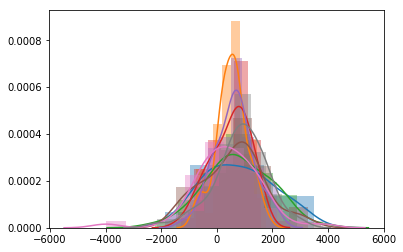

In [26]:
sns.distplot(samp_len_0)
sns.distplot(samp_len_255)
sns.distplot(samp_len_317)
sns.distplot(samp_len_394)
sns.distplot(samp_len_561)
sns.distplot(samp_len_823)
sns.distplot(samp_len_928)
sns.distplot(samp_len_958)

In [27]:
hf.test_normality(samp_len_0)
hf.test_normality(samp_len_255)
hf.test_normality(samp_len_317)
hf.test_normality(samp_len_394)
hf.test_normality(samp_len_561)
hf.test_normality(samp_len_823)
hf.test_normality(samp_len_928)
hf.test_normality(samp_len_958)

p= 0.6125956177711487
 The data is normally distributed.
p= 0.5751800537109375
 The data is normally distributed.
p= 0.9683454036712646
 The data is normally distributed.
p= 0.11091955751180649
 The data is normally distributed.
p= 0.8645208477973938
 The data is normally distributed.
p= 0.4008171558380127
 The data is normally distributed.
p= 0.03176334872841835
 The data is not normally distributed.
p= 0.23828746378421783
 The data is normally distributed.


True

In [28]:
hf.test_equal_variance(samp_len_0, samp_len_255)

p= 4.3697320943514287e-07
 Variances are not equal.


False

In [29]:
test_df = pd.DataFrame()
test_df['samp_len_0'] = samp_len_0
test_df['samp_len_255'] = samp_len_255
test_df['samp_len_317'] = samp_len_317
test_df['samp_len_394'] = samp_len_394
test_df['samp_len_561'] = samp_len_561
test_df['samp_len_823'] = samp_len_823
test_df['samp_len_928'] = samp_len_928
test_df['samp_len_958'] = samp_len_958

In [30]:
formula = 'samp_len_958 ~ samp_len_255 + samp_len_317 + samp_len_394 + samp_len_561 + samp_len_823 + samp_len_928 + samp_len_0'
lm = ols(formula, test_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           samp_len_958   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.159
Date:                Wed, 13 Nov 2019   Prob (F-statistic):              0.347
Time:                        09:45:05   Log-Likelihood:                -409.79
No. Observations:                  50   AIC:                             835.6
Df Residuals:                      42   BIC:                             850.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      776.6861    341.590      2.274      0.028      87.330    1466.043
samp_len_255     0.1681      0.253      0.665      0.510      -0.342       0.678
samp_len_317     0.0298      0.127      0.234      0.816      -0.227       0.287
samp_len_394     0.3017      0.200      1.509      0.139      -0.102       0.705
samp_len_561     0.0368      0.210      0.175      0.862      -0.387       0.461
samp_len_823    -0.2478      0.130     -1.912      0.063      -0.509       0.014
samp_len_928     0.0685      0.120      0.571      0.571      -0.174       0.311
samp_len_0      -0.1037      0.121     -0.858      0.396      -0.348       0.140
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.643
Skew:                          -0.028   Prob(JB):                        0.725
Kurtosis:                       2.447   Cond. No.                     4.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
H, pval = mstats.kruskalwallis(samp_len_0, samp_len_255, samp_len_317, samp_len_394, samp_len_561, samp_len_823, samp_len_928, samp_len_958)
print('H-stat', H)
print('pvalue', pval)

H-stat 9.867516209476207
pvalue 0.19620635530056438


From the Kruskal_Wallace above, the p-value greater than .05 indicates that the data is of the same distribution
with this result, we __fail to reject our Null H0__